# Multiclass classification using a neural network

Here we adopt a 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold

import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2761236577674734161
]


In [16]:
matrix = pd.read_csv('model/1129-fixed-data-matrix-karlgren.csv').set_index('character')
with open('full-ordering.json', encoding='utf-8') as f:
    matrix = matrix[json.load(f)]

In [17]:
import json
with open('hypothesized_phonetic_series.json', encoding='utf8') as f:
    js = json.load(f)

In [18]:
def getps(char):
    if char in js:
        return js[char]
    else:
        return 0
def rowIndex(row):
    return getps(row.name)
matrix['ps'] = matrix.apply(rowIndex, axis=1)
one_hot = pd.get_dummies(matrix['ps'], prefix = 'ps')
dropval = 3
print(one_hot.shape)
one_hot.drop([col for col, val in one_hot.sum().iteritems() if val < dropval], axis=1, inplace=True)
print(one_hot.shape)
matrix = matrix.drop('ps', axis = 1)
matrix = matrix.join(one_hot)
matrix.columns
matrix.head()

(15250, 4097)
(15250, 981)


,mando_onset_b,mando_onset_c,mando_onset_ch,mando_onset_d,mando_onset_f,mando_onset_g,mando_onset_h,mando_onset_j,mando_onset_k,mando_onset_l,...,ps_𢆉,ps_𢆶,ps_𣪠,ps_𤔔,ps_𥁕,ps_𦐇,ps_𦣝,ps_𦣻,ps_𦥑,ps_𧴪
character,,,,,,,,,,,,,,,,,,,,,
㐁,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐆,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐭,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
㐱,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
㐲,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
cols = matrix.columns
features_cols = [c for c in cols if 'Karlgren' not in c and 'tone_label' not in c]
labels_cols = [c for c in cols if c not in features_cols]

In [20]:
X_complete = matrix[features_cols]
Y_complete = matrix[labels_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X_complete, Y_complete, test_size=.3, random_state=0)

In [21]:
label_categories = [
#     'tone_label',
#     'Karlgren_onset',
#     'Karlgren_nucleus',
    'Karlgren_coda'
]

In [22]:
Y_train.head()

,tone_label_checked,tone_label_departing,tone_label_level,tone_label_rising,Karlgren_onset_bʱ,Karlgren_onset_p,Karlgren_onset_pʰ,Karlgren_onset_m,Karlgren_onset_dʱ,Karlgren_onset_tʰ,...,Karlgren_nucleus_ə,Karlgren_nucleus_ə̯u,Karlgren_nucleus_ɨ̯ɐ,Karlgren_coda_p̚,Karlgren_coda_t̚,Karlgren_coda_k̚,Karlgren_coda_m,Karlgren_coda_n,Karlgren_coda_ŋ,Karlgren_coda_∅
character,,,,,,,,,,,,,,,,,,,,,
藝,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
趢,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
匿,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
隈,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
櫓,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
def fit_keras_models(X, X_test, Y, Y_test, architecture, n_epochs=200, n_folds=5):
    category_to_performance = defaultdict(list)
    category_to_test_performance = defaultdict(list)
    category_to_callbacks = defaultdict(list)
    
    for category in label_categories:
        Y_subset = Y[[x for x in Y.columns if category in x]]
        Y_test_subset = Y_test[[x for x in Y_test.columns if category in x]]
        n_bins = Y_subset.shape[1]
        
        def build_keras_nn_model():
            model = Sequential()
            model.add(Dense(
                architecture[0][0],
                input_dim=X.shape[1],
                activation=architecture[0][1])
            )
            
            if len(architecture) > 1:
                for l, (hidden_layer_size, act_fn) in enumerate(architecture[1:]):
                    if act_fn is 'dropout':
                        model.add(Dropout(
                            rate=hidden_layer_size
                        ))
                    else:
                        model.add(Dense(
                            hidden_layer_size,
                            input_dim=architecture[l - 1],
                            activation=act_fn)
                        )
                    
            model.add(Dense(n_bins, activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        
        KerasNN = KerasClassifier(
            build_fn=build_keras_nn_model,
            epochs=n_epochs,
            batch_size=256,
            verbose=True
        )
        
        kf = KFold(n_splits=n_folds, random_state=0, shuffle=False)
        for kf_idx, (train_idx, dev_idx) in enumerate(kf.split(X)):
            X_train, X_dev = X.iloc[train_idx], X.iloc[dev_idx]
            Y_train, Y_dev = Y_subset.iloc[train_idx], Y_subset.iloc[dev_idx]
            
            hist_callback = KerasNN.fit(
                X_train,
                Y_train,
                validation_data=(X_dev, Y_dev)
            )
            
            category_to_callbacks[category].append(hist_callback)
            dev_score = KerasNN.score(X_dev, Y_dev)
            category_to_performance[category].append(dev_score)
            test_acc = KerasNN.score(X_test, Y_test_subset)
            category_to_test_performance[category].append(test_acc)
            print('Category: {:16s}\tCV: {} of {}\tDev performance: {:.3f}'.format(
                category, kf_idx + 1, n_folds, float(dev_score)))
    return category_to_performance, category_to_callbacks, category_to_test_performance

In [50]:
N_EPOCHS = 5
N_FOLDS = 5
ARCHITECTURE = [
    (96, 'relu'),
    (32, 'relu'),
]
performance, callbacks, test_performance = fit_keras_models(
    X_train,
    X_test,
    Y_train,
    Y_test,
    architecture=ARCHITECTURE,
    n_epochs=N_EPOCHS,
    n_folds=N_FOLDS
)
print("DONE")

Train on 8558 samples, validate on 2140 samples
Epoch 1/5
8558/8558 [==============================] - 5s 565us/step - loss: 1.4060 - acc: 0.4621 - val_loss: 0.9145 - val_acc: 0.7047
Epoch 2/5
8558/8558 [==============================] - 1s 116us/step - loss: 0.5454 - acc: 0.8442 - val_loss: 0.3373 - val_acc: 0.9164
Epoch 3/5
8558/8558 [==============================] - 1s 65us/step - loss: 0.2347 - acc: 0.9246 - val_loss: 0.2261 - val_acc: 0.9243
Epoch 4/5
8558/8558 [==============================] - 1s 67us/step - loss: 0.1653 - acc: 0.9292 - val_loss: 0.1976 - val_acc: 0.9248
Epoch 5/5
4586/4586 [==============================] - 0s 20us/step
Category: Karlgren_coda   	CV: 1 of 5	Dev performance: 0.925
Train on 8558 samples, validate on 2140 samples
Epoch 1/5
8558/8558 [==============================] - 6s 727us/step - loss: 1.3736 - acc: 0.6068 - val_loss: 0.7914 - val_acc: 0.7495
Epoch 2/5
8558/8558 [==============================] - 1s 86us/step - loss: 0.4894 - acc: 0.8626 - val

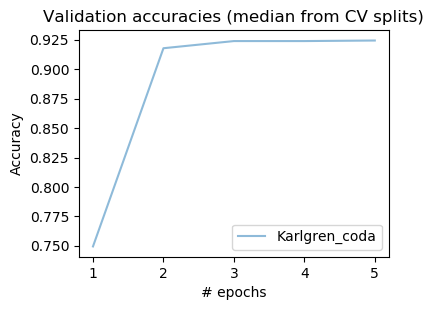

In [53]:
MODE = 'median'
# MODE = 'best'

ax = plt.figure(figsize=(4,3), dpi=100)
plt.title('Validation accuracies (' + MODE + ' from CV splits)')
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
xrange = range(1, N_EPOCHS + 1)
plt.xticks(xrange, xrange)
for category in label_categories:
    if MODE == 'median':
        run_idx = performance[category].index(sorted(performance[category])[len(performance[category]) // 2])
    else:
        run_idx = performance[category].index(max(performance[category]))
    hist = callbacks[category][run_idx].history
    plt.plot(xrange, hist['val_acc'], label=category, alpha=.5)
plt.legend(loc='lower right')
plt.show()
ax.savefig('nn-cv-val-acc.png', format='png')

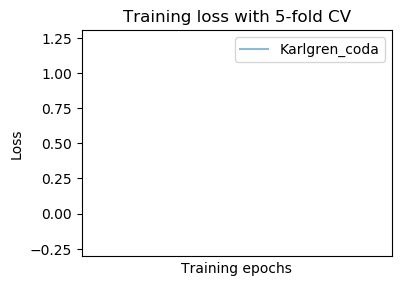

In [54]:
ax = plt.figure(figsize=(4,3), dpi=100)
plt.title('Training loss with 5-fold CV')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
xrange = range(1, N_EPOCHS + 1 - 5)
plt.xticks(xrange, xrange)
for idx, category in enumerate(label_categories):
    for fold in range(N_FOLDS):
        val_acc = callbacks[category][fold].history['loss'][:-5]
        if not fold: 
            plt.plot(xrange, val_acc, label=category, color='C' + str(idx), alpha=.5)
        else:
            plt.plot(xrange, val_acc, label='__nolegend__', color='C' + str(idx), alpha=.5)
plt.legend()
# plt.tight_layout()
plt.show()
# ax.savefig('nn-cv-train-loss.eps', format='eps')

In [55]:
avg = 0
for cat in label_categories:
    best_idx = performance[cat].index(max(performance[cat]))
    print('{:16s}\t{:2.3f}%'.format(cat, 100 * test_performance[cat][best_idx]))
    avg += 100 * test_performance[cat][best_idx]
print("Average: " + str(avg / 4))

Karlgren_coda   	92.303%
Average: 23.075665036404025


In [56]:
test_performance

defaultdict(list,
            {'Karlgren_coda': [0.9238988212295562,
              0.9245529860531041,
              0.9245529860531041,
              0.923026601456161,
              0.9228085464803194]})

In [57]:
len(Y_complete[[x for x in Y_complete.columns if 'nucleus' in x]].columns)

62